In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import torch as tch
from torch import nn, Tensor

In [4]:
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = [12, 8]
plt.style.use("dark_background")

In [5]:
dev = tch.device("cuda")
dtype = tch.float32

In [6]:
from genpg.dataset import read_train_data, read_test_data

(train_labels, train_images) = read_train_data()
(test_labels, test_images) = read_test_data()

In [7]:
def make_images(img: np.ndarray) -> Tensor:
    return tch.from_numpy(img).to(dev).type(dtype) / 255.0

In [8]:
from torch.nn.functional import softplus

def normal_log_prob(z_mean: Tensor, z_scale: Tensor):
    "KL-divergence between N(0,1) and N(z_mean,z_scale)"
    z_var = z_scale.pow(2)
    return -0.5 * (1.0 + z_var.log() - z_mean.pow(2) - z_var).mean(1)

def sample_latent(z_distr: Tensor) -> tuple[Tensor, Tensor]:
    "Returns: (z, log_q_z)"

    latent_dim = z_distr.shape[1] // 2
    z_mean, z_scale = z_distr[:, :latent_dim], z_distr[:, latent_dim:]
    z_scale = softplus(z_scale)

    z = z_mean + z_scale * tch.randn_like(z_scale)
    log_q_z = normal_log_prob(z_mean, z_scale)

    return z, log_q_z


In [29]:
from genpg.model import Encoder, Decoder

image_dims = test_images.shape[1:]
latent_dim = 256

conv_channels = [[1, 8, 8, 8], [8, 16], [16, 32]]
kernel_size = 3
fc_dims = [2 * 784, 1024]

enc = Encoder(image_dims, conv_channels, kernel_size, [*fc_dims, 2 * latent_dim]).to(dev)
print(enc)
dec = Decoder([latent_dim, *reversed(fc_dims)], [list(reversed(s)) for s in reversed(conv_channels)], kernel_size, image_dims).to(dev)
print(dec)

Encoder(
  (conv): ConvNet(
    (0): ConvLayer(
      (convs): Sequential(
        (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (1): ReLU()
        (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (3): ReLU()
        (4): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=same)
      )
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): ConvLayer(
      (convs): Sequential(
        (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
      )
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): ConvLayer(
      (convs): Sequential(
        (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
      )
    )
  )
  (mlp): Mlp(
    (0): Linear(in_features=1568, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=512, bias=True)
  )
)
Decoder(
  (mlp): Mlp(
   

In [30]:
batch_size = 256
reg_factor = 0.1

optim = tch.optim.AdamW(
    list(enc.parameters()) + list(dec.parameters()),
    lr=1e-3,
)

In [31]:
def sample_fig(dec: Decoder, z: Tensor):
    dec.train(False)

    y = dec.forward(z).sigmoid()
    images = y.detach().cpu().numpy()

    fig, axs = plt.subplots(1, y.shape[0])
    for i in range(y.shape[0]):
        ax = axs[i]
        ax.axis('off')
        ax.imshow(images[i], interpolation='nearest')

    return fig

'epoch = 39'

{'reconstruction_loss': np.float64(0.01037512509984539),
 'regularization_term': np.float64(0.0912138062905758),
 'total_loss': np.float64(0.019496505897729954)}

{'reconstruction_loss': np.float64(0.010583886783570052)}

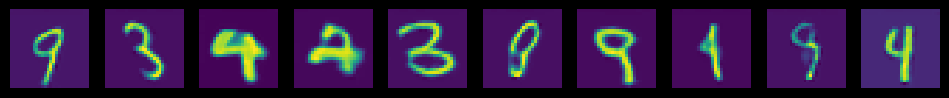

In [32]:
from torch.nn.functional import mse_loss, binary_cross_entropy_with_logits as bce_with_logits
from genpg.dataset import generate_batches
from genpg.utils import Accum
from genpg.notebook import Display

test_z = tch.randn((10, latent_dim), device=dev)
display = Display()

for epoch in range(40):

    enc.train(True)
    dec.train(True)

    train_stats = Accum("reconstruction_loss", "regularization_term", "total_loss")
    for labels, images in generate_batches(batch_size, train_labels, train_images):
        images = make_images(images)

        enc.zero_grad()
        dec.zero_grad()

        x = images
        z_distr = enc.forward(x)
        z, log_q_z = sample_latent(z_distr)
        y = dec.forward(z)

        rec_loss = mse_loss(y, x, reduction="mean")
        reg_term = log_q_z.mean(0)
        loss = rec_loss + reg_factor * reg_term

        loss.backward()
        optim.step()

        train_stats.append(rec_loss.item(), reg_term.item(), loss.item())

    enc.train(False)
    dec.train(False)

    val_stats = Accum("reconstruction_loss")
    for labels, images in generate_batches(batch_size, test_labels, test_images):
        images = make_images(images)
        
        x = images
        z_distr = enc.forward(x)
        z, log_q_z = sample_latent(z_distr)
        y = dec.forward(z)

        loss = mse_loss(y, x, reduction="mean")
        val_stats.append(loss.item())
    

    fig = sample_fig(dec, test_z)

    display.clear()
    display.update(f"{epoch = }")
    display.update(train_stats.mean())
    display.update(val_stats.mean())
    display.update(fig)
    plt.close()



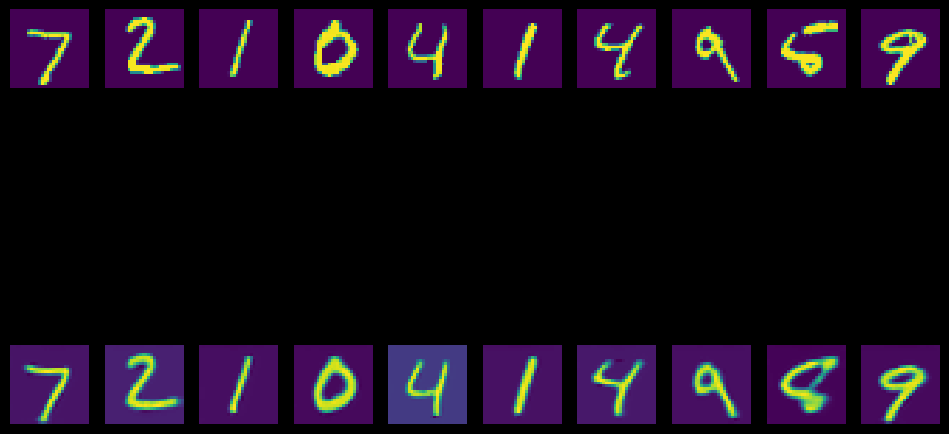

In [33]:
enc.train(False)
dec.train(False)

n = 10
x = make_images(test_images[0:n])
z = sample_latent(enc.forward(x))[0]
y = dec.forward(z).sigmoid()

fig, axs = plt.subplots(2, n)
for col, t in enumerate([x, y]):
    img = t.detach().cpu().numpy()
    for row in range(n):
        ax = axs[col, row]
        ax.axis('off')
        ax.imshow(img[row], interpolation='nearest')
fig.show()

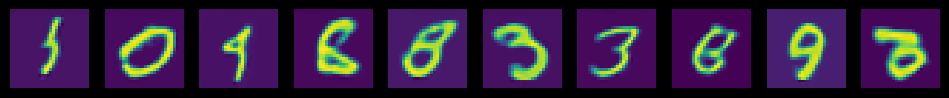

In [34]:
sample_fig(dec, tch.randn((10, latent_dim), device=dev)).show()

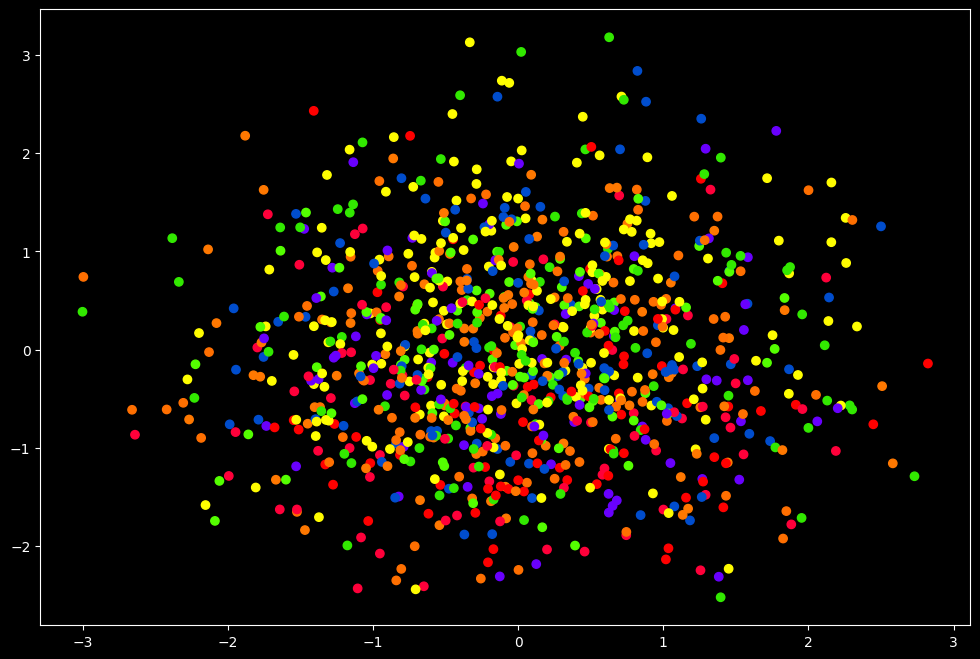

In [35]:
enc.train(False)

n = 1000
c = test_labels[:n]
x = make_images(test_images[:n])
z = sample_latent(enc.forward(x))[0].detach().cpu().numpy()

x, y = z[:,0], z[:,1]
plt.scatter(x, y, c=c, cmap="prism")